# Node Classification on large Knowledge Graphs
Predict the label of Node based on other features of node in graph

Based on [this exercise](https://colab.research.google.com/drive/14OvFnAXggxB8vM4e8vSURUp1TaKnovzX?usp=sharing#scrollTo=paMH3_7ejSg4).

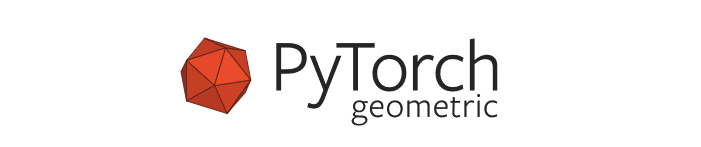

## Installing PyTorch Geometric and RDKit

- **PyTorch Geometric**: For building graph neural networks (GNNs).
- **RDKit**: For handling molecular data.
- **torch-scatter**: Provides efficient scatter operations for PyTorch tensors, essential for aggregating or distributing data across nodes in a graph structure.
- **torch-sparse**: Optimized for handling sparse matrices in PyTorch, crucial for GNNs where adjacency matrices are often sparse.
- **torch-cluster**: Includes clustering algorithms optimized for PyTorch, useful for tasks like node clustering or neighborhood sampling in graph processing.
- **torch-spline-conv**: Implements spline-based convolutional layers for graph data, enhancing GNNs by applying convolutional operations with spline functions to capture complex node relationships.

**References**
- [torch-geometric PyPI](https://pypi.org/project/torch-geometric/)
- [torch-scatter PyPI](https://pypi.org/project/torch-scatter/)
- [torch-sparse PyPI](https://pypi.org/project/torch-sparse/)
- [torch-cluster PyPI](https://pypi.org/project/torch-cluster/)
- [torch-spline-conv PyPI](https://pypi.org/project/torch-spline-conv/)
- [RDKit Official Documentation](https://www.rdkit.org/docs/Install.html#cross-platform-using-pip)

In [ ]:
!pip install torch -q
!pip install torchvision -q
!pip install torch-geometric -q
!pip install rdkit -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.1/33.1 MB 24.1 MB/s eta 0:00:00


In [ ]:
import torch

pytorch_version = f"torch-{torch.__version__}.html"
!pip install --no-index torch-scatter -f https://pytorch-geometric.com/whl/$pytorch_version -q
!pip install --no-index torch-sparse -f https://pytorch-geometric.com/whl/$pytorch_version -q
!pip install --no-index torch-cluster -f https://pytorch-geometric.com/whl/$pytorch_version -q
!pip install --no-index torch-spline-conv -f https://pytorch-geometric.com/whl/$pytorch_version -q

ERROR: Could not find a version that satisfies the requirement torch-scatter (from versions: none)
ERROR: No matching distribution found for torch-scatter
ERROR: Could not find a version that satisfies the requirement torch-sparse (from versions: none)
ERROR: No matching distribution found for torch-sparse
ERROR: Could not find a version that satisfies the requirement torch-cluster (from versions: none)
ERROR: No matching distribution found for torch-cluster
ERROR: Could not find a version that satisfies the requirement torch-spline-conv (from versions: none)
ERROR: No matching distribution found for torch-spline-conv


## Knowledge Graphs and Node Classification

There are two special properties we are dealing with in this example:
1. We have one large graph and not many individual graphs (like molecules)
2. We infere on unlabeled nodes in this large graph and hence perform node-level predictions --> We have to use different nodes of the graph depending on what we want to do

## Dataset Introduction

There exists different datasets in PyTorch Geometric that can be used to perform Node Classification on large Knowledge Graphs e.g. Karate Network or Cora. We will use Cora to showcase the use of binary masks for node-level predictions.





#### What is the Cora Dataset?
The Cora dataset consists of 2708 scientific publications classified into one of seven classes. Each publication in the dataset is described by a 0/1-valued word vector indicating the absence/presence of the corresponding word from the dictionary. The dictionary consists of 1433 unique words.

- Nodes = Publications (Papers, Books ...)
- Edges = Citations
- Node Features = word vectors(Bag Of Word Represntation)
- 7 Labels = Pubilcation type e.g. Neural_Networks, Rule_Learning, Reinforcement_Learning, 	Probabilistic_Methods...

*The BoW representation results in a vector where each entry corresponds to the frequency of a specific word in the document. For the Cora dataset, which includes about 3,000 publications, this vector has a fixed size of 1,433 elements, each representing the count of a specific word in the document.*

We normalize the features using torch geometric's transform functions.

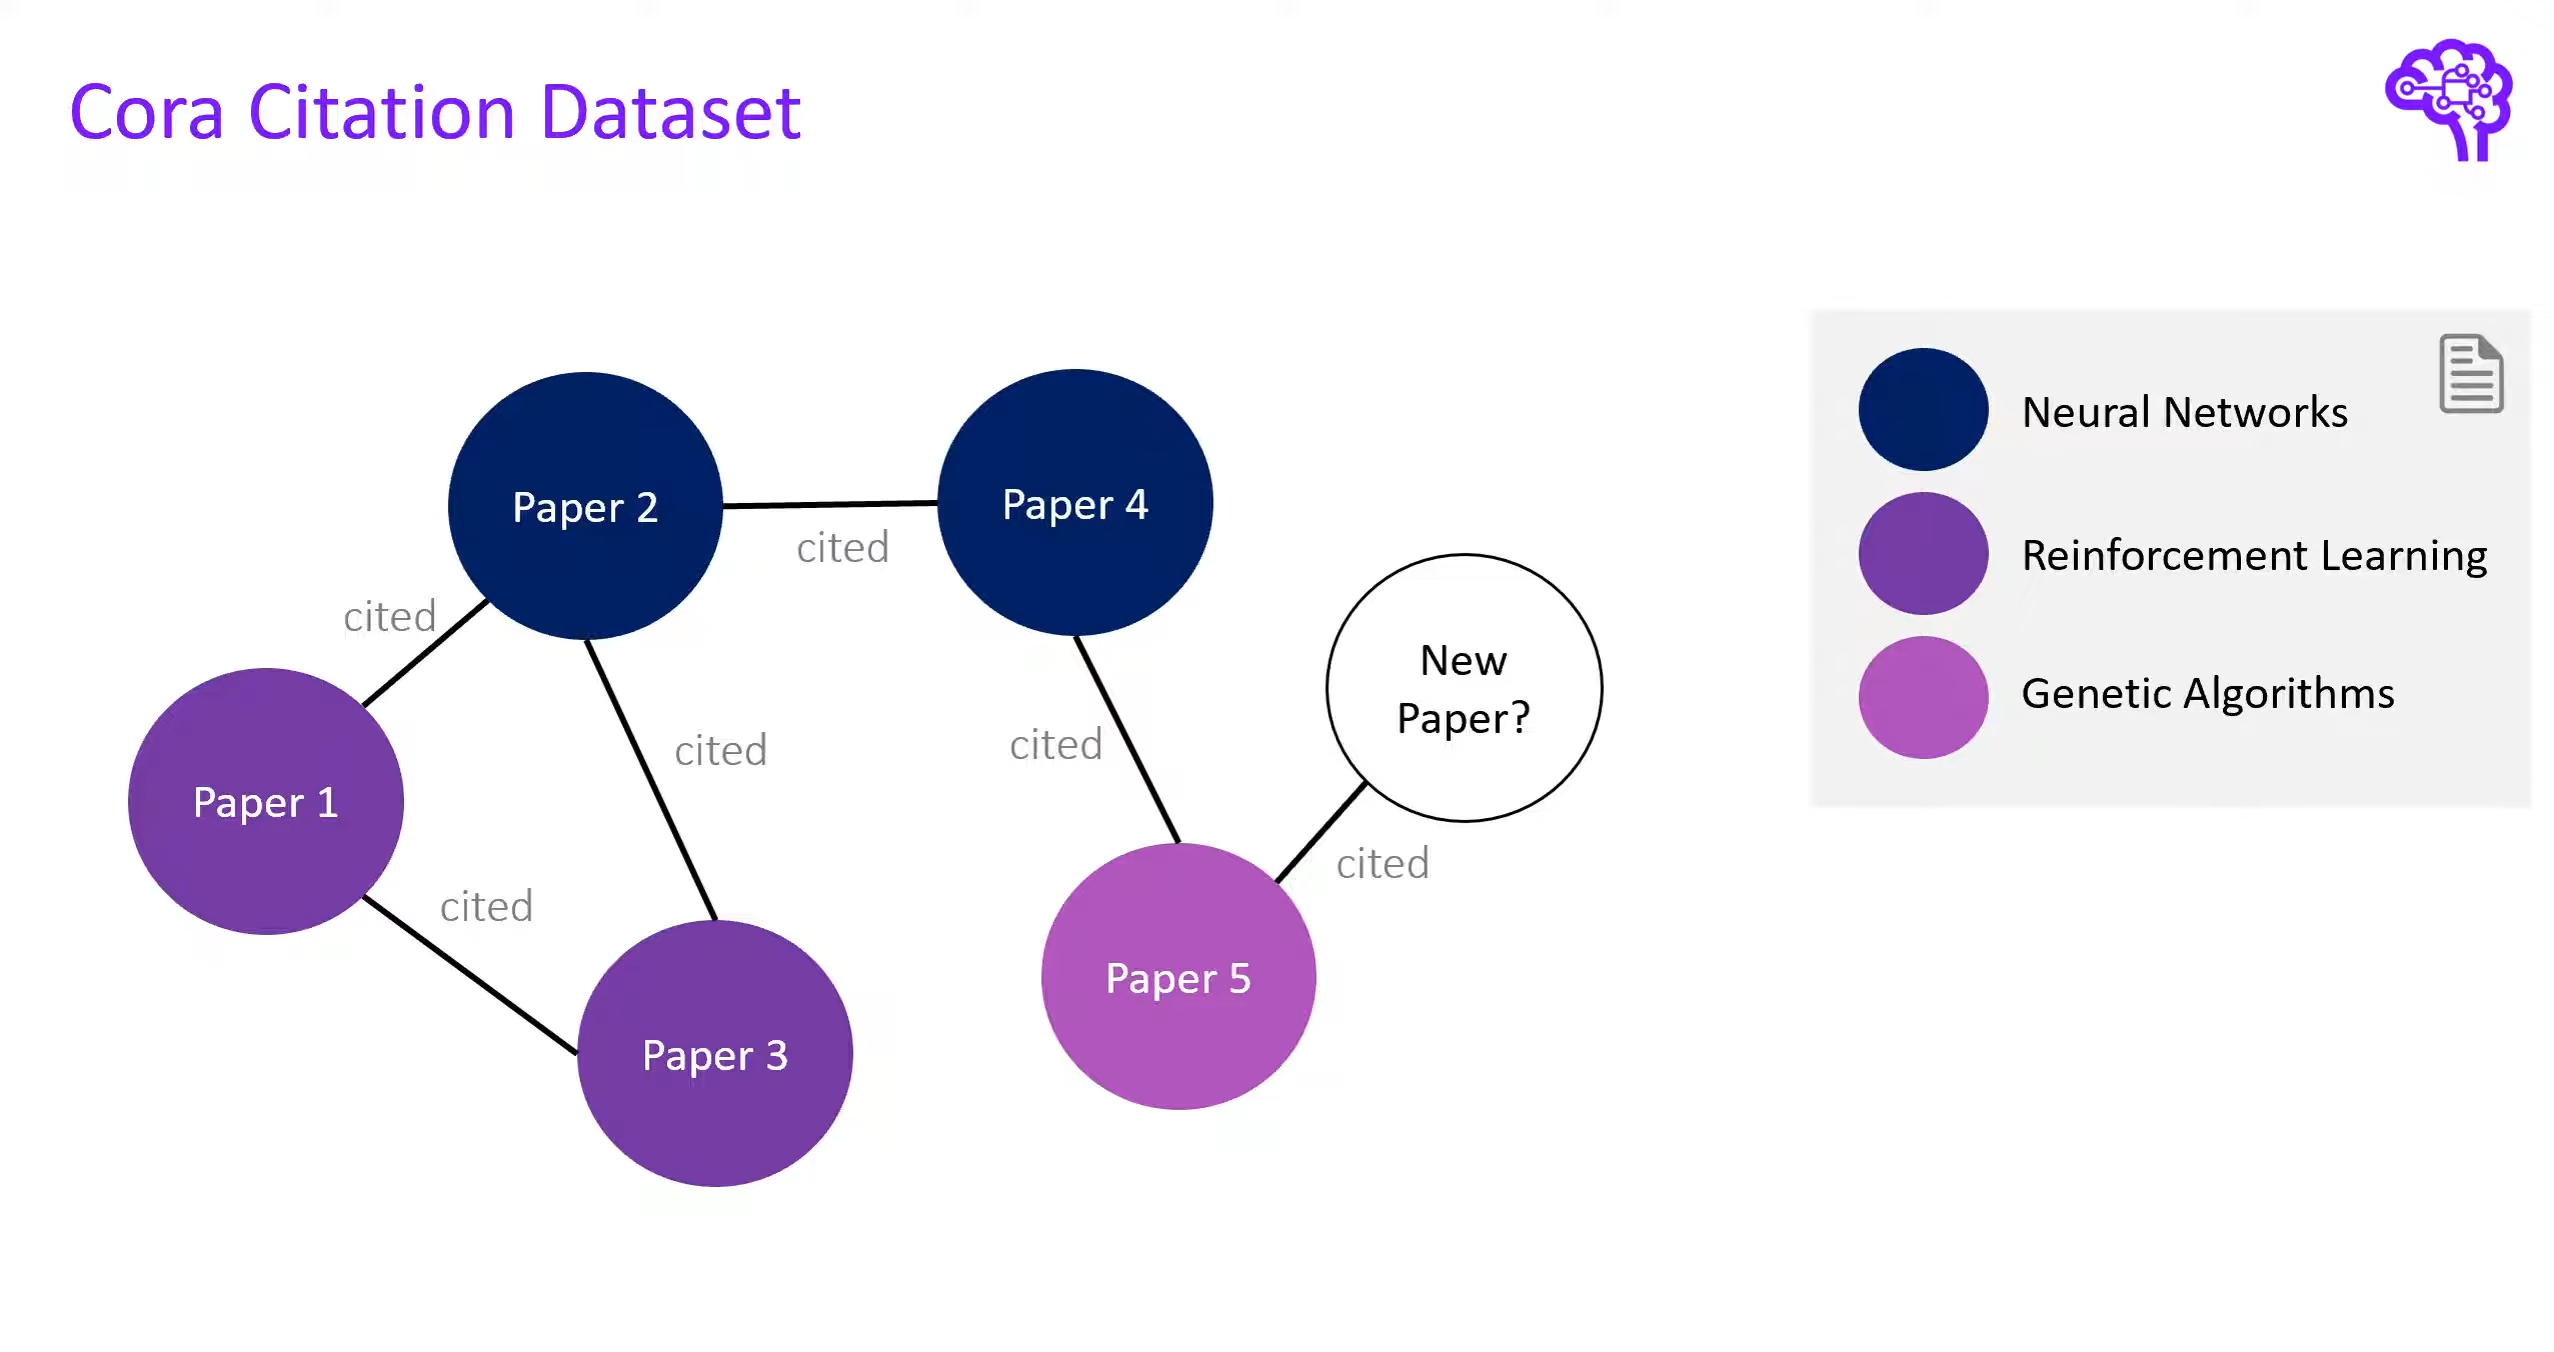

In [ ]:
import collections
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt
from tqdm.auto import tqdm

from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

In [ ]:
dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())

Processing...
Done!


In [ ]:
id_to_labels = {
    0: "Theory",
    1: "Reinforcement_Learning",
    2: "Genetic_Algorithms",
    3: "Neural_Networks",
    4: "Probabilistic_Methods",
    5: "Case_Based",
    6: "Rule_Learning"
}

PyTorch Geometric provides different functions to investigate the dataset (e.g. node degrees, self-loops ect.) - You can find more of them in the documentation or in [this notebook](https://colab.research.google.com/drive/14OvFnAXggxB8vM4e8vSURUp1TaKnovzX?usp=sharing#scrollTo=eqWR0j_kIx67).

In [ ]:
# Get some basic info about the dataset
print(f'Number of graphs: {len(dataset)}')
print(f'Number of node features: {dataset.num_node_features}')
print(f'Number of classes: {dataset.num_classes}')
print(50*'=')

# There is only one graph in the dataset, use it as new data object
data = dataset[0]

# Gather some statistics about the graph.
print(data)
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Is undirected: {data.is_undirected()}')

Number of graphs: 1
Number of node features: 1433
Number of classes: 7
Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
Number of nodes: 2708
Number of edges: 10556
Number of training nodes: 140
Training node label rate: 0.05
Is undirected: True


In [ ]:
# mask with true value is chossen for validation, training and testing for each
print("Total training nodes: ", data.train_mask.sum())
print("Total validation nodes: ", data.val_mask.sum())
print("Total testing nodes: ", data.test_mask.sum())

Total training nodes:  tensor(140)
Total validation nodes:  tensor(500)
Total testing nodes:  tensor(1000)


Observations:
- We only have a relatively small set of training nodes (20 nodes per class)
- There are binary test, train and validation masks of the size #nodes (they tell use which node can be used for which task)

In [ ]:
print(data.x.shape) # [No. Nodes x Features]

# Print some of the normalized word counts of the first datapoint
data.x[0][:50]

torch.Size([2708, 1433])


tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.1111, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000])

Why do we even use the graph structure - aren't the features enough?

- Apparently, simple MLP models perform a lot worse than GNNs on this type of task, as the citation information is crucial for a correct classification

How do the labels look like?
- They are encoded as numeric value between 0-6

In [ ]:
labels = data.y
labels

tensor([3, 4, 4,  ..., 3, 3, 3])

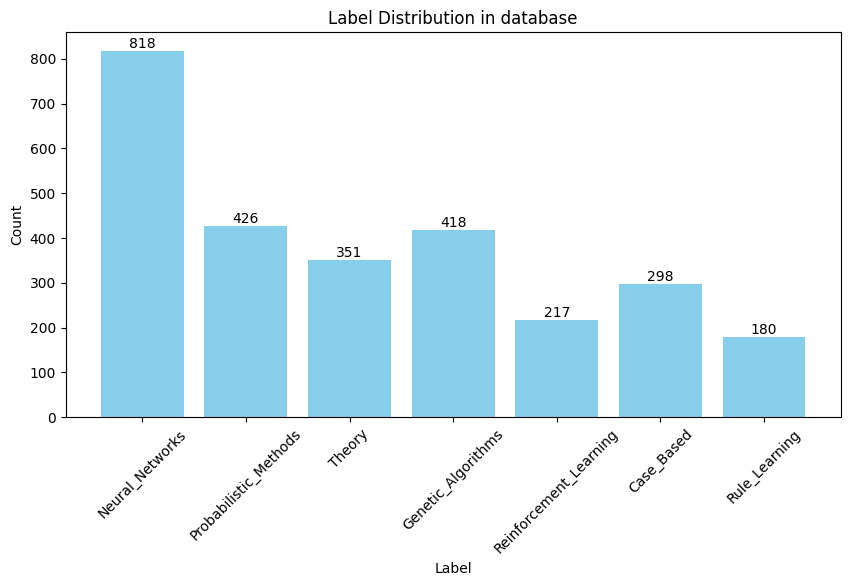

In [ ]:
# countt number of each label in dataset
label_counts = collections.Counter(labels.numpy())

# convert the label IDs to human-readable names using the id_to_labels dict
label_names = [id_to_labels[label_id] for label_id in label_counts.keys()]
count_values = list(label_counts.values())

plt.figure(figsize=(10,5), frameon=False)
bars = plt.bar(label_names, count_values, color="skyblue")

# displaying value count in the bar graph
for bar in bars:
  yval = bar.get_height()
  plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval),
          ha="center", va="bottom")
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Label Distribution in database')
plt.xticks(rotation=45)
plt.show()

Example for the binary masks

In [ ]:
print(len(data.test_mask) == data.num_nodes)
data.test_mask

True


tensor([False, False, False,  ...,  True,  True,  True])

Example for the edge connections

In [ ]:
data.edge_index.t()

tensor([[ 633,    0],
        [1862,    0],
        [2582,    0],
        ...,
        [ 598, 2707],
        [1473, 2707],
        [2706, 2707]])

## Graph Neural Network for Node Classification

In [ ]:
import torch
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv #GATConv

class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(42)

        # Initialize the layers
        self.conv1 = GCNConv(dataset.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.out = Linear(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index):
        # First Message Passing Layer (Transformation)
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)

        # Second Message Passing Layer
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)

        # Output layer
        x = F.softmax(self.out(x), dim=1)
        return x

model = GCN(hidden_channels=16)
print(model)

GCN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 16)
  (out): Linear(in_features=16, out_features=7, bias=True)
)


Observations:
- Dropout is only applied in the training step, but not for predictions
- We have 2 Message Passing Layers and one Linear output layer
- We use the softmax function for the classification problem
- The output of the model are 7 probabilities, one for each class

## Training and Evaluation

In [ ]:
# Initialize model
model = GCN(hidden_channels=16)

# Use GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
data = data.to(device)

# Initialize Optimizer
learning_rate = 0.01
decay = 5e-4
optimizer = torch.optim.Adam(model.parameters(),
                             lr=learning_rate,
                             weight_decay=decay)
# Define loss function (CrossEntropyLoss for Classification Problems with
# probability distributions)
criterion = torch.nn.CrossEntropyLoss()

def train():
      model.train()
      optimizer.zero_grad()
      # Use all data as input, because all nodes have node features
      out = model(data.x, data.edge_index)
      # Only use nodes with labels available for loss calculation --> mask
      loss = criterion(out[data.train_mask], data.y[data.train_mask])
      loss.backward()
      optimizer.step()
      return loss

def test():
      model.eval()
      out = model(data.x, data.edge_index)
      # Use the class with highest probability.
      pred = out.argmax(dim=1)
      # Check against ground-truth labels.
      test_correct = pred[data.test_mask] == data.y[data.test_mask]
      # Derive ratio of correct predictions.
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum())
      return test_acc

losses = []
for epoch in tqdm(range(0, 1001)):
    loss = train()
    losses.append(loss)
    if epoch % 100 == 0:
      print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

  0%|          | 0/1001 [00:00<?, ?it/s]

Epoch: 000, Loss: 1.9461
Epoch: 100, Loss: 1.8616
Epoch: 200, Loss: 1.7218
Epoch: 300, Loss: 1.6939
Epoch: 400, Loss: 1.6406
Epoch: 500, Loss: 1.5496
Epoch: 600, Loss: 1.4957
Epoch: 700, Loss: 1.4611
Epoch: 800, Loss: 1.4322
Epoch: 900, Loss: 1.3927
Epoch: 1000, Loss: 1.3463


#### Visualize the training loss

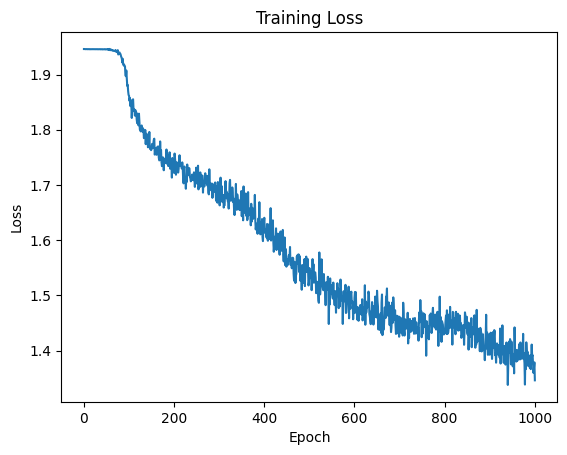

In [ ]:
losses_float = [float(loss.cpu().detach().numpy()) for loss in losses]
loss_indices = [i for i, l in enumerate(losses_float)]

sns.lineplot(x=loss_indices, y=losses_float)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

Calculate test metric

In [ ]:
test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.6940


In [ ]:
print("Shape of X: [num_nodes, num_nodes_feature]", data.x.shape)
print("Shape of edge: [, total_edge_in_graph]", data.edge_index.shape)

Shape of X: [num_nodes, num_nodes_feature] torch.Size([2708, 1433])
Shape of edge: [, total_edge_in_graph] torch.Size([2, 10556])


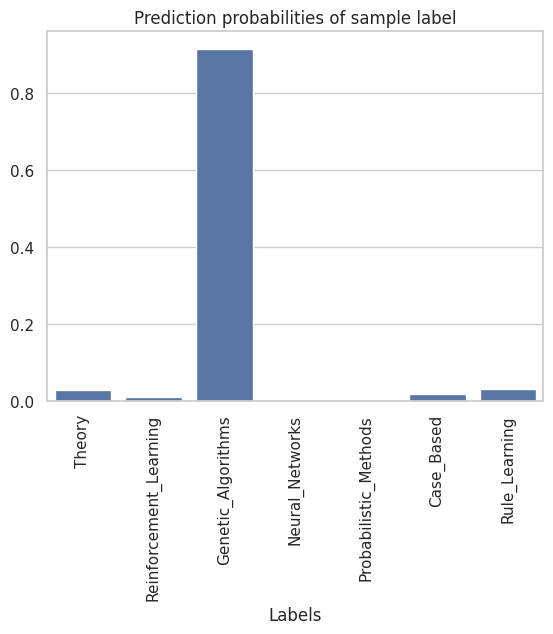

In [ ]:
sample = 9
sns.set_theme(style="whitegrid")
pred = model(data.x, data.edge_index)
sns.barplot(x=[id_to_labels[i] for i in range(7)], y=pred[sample].detach().cpu().numpy())
plt.xticks(rotation=90)
plt.title("Prediction probabilities of sample label")
plt.xlabel("Labels")
plt.show()

### Visualizing the embeddings

The `plt2arr(fig)` function converts a `matplotlib` figure (`fig`) into a NumPy array representing its pixel data in RGB format.

- `tostring_rgb()` extracts the RGB pixel values from the figure's canvas as a byte string.
- `get_width_height()` gets the width (`w`) and height (`h`) of the figure.
- `np.frombuffer()` converts the byte string into a NumPy array of shape `(h, w, 3)`, where each pixel is represented by an RGB triplet.


In [ ]:
from sklearn.manifold import TSNE

def plt2arr(fig):
    rgb_str = fig.canvas.tostring_rgb()
    (w,h) = fig.canvas.get_width_height()
    rgba_arr = np.frombuffer(rgb_str, dtype=np.uint8).reshape((w,h,-1))
    return rgba_arr


def visualize(out, color, epoch):
    fig = plt.figure(figsize=(5,5), frameon=False)
    fig.suptitle(f'Epoch = {epoch}')
    # Fit TSNE with 2 components
    z = TSNE(n_components=2).fit_transform(out.detach().cpu().numpy())

    # Create scatterplot from embeddings
    plt.xticks([])
    plt.yticks([])
    plt.scatter(z[:, 0],
                z[:, 1],
                s=70,
                c=color.detach().cpu().numpy(),
                cmap="Set2")
    fig.canvas.draw()
    # convert to numpy
    image_array = plt2arr(fig)
    # close the figure to prevent memory issue
    plt.close()
    return image_array



# Reset the previously trained model weights
for layer in model.children():
   if hasattr(layer, 'reset_parameters'):
       layer.reset_parameters()

In [ ]:
# Train the model and save visualizations
images = []
for epoch in tqdm(range(0, 10000)):
    loss = train()
    if epoch % 50 == 0:
      out = model(data.x, data.edge_index)
      images.append(visualize(out, color=data.y, epoch=epoch))
print("TSNE Visualization finished.")

  0%|          | 0/10000 [00:00<?, ?it/s]

TSNE Visualization finished.


#### Building a GIF from this

In [ ]:
!pip install moviepy -q

In [ ]:
from moviepy.editor import ImageSequenceClip

fps = 1
filename = "/content/embeddings.gif"
clip = ImageSequenceClip(images, fps=fps)
clip.write_gif(filename, fps=fps)

MoviePy - Building file /content/embeddings.gif with imageio.


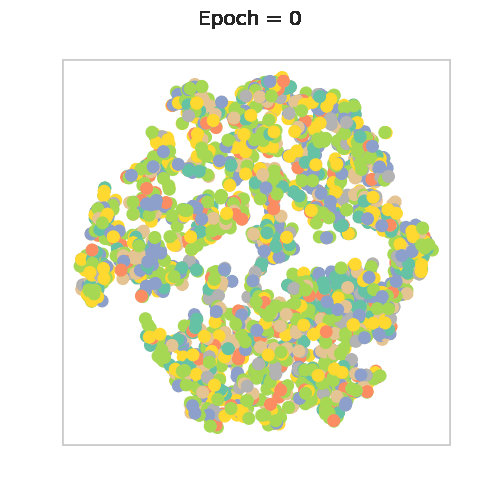

In [ ]:
from IPython.display import Image
with open('/content/embeddings.gif','rb') as f:
    display(Image(data=f.read(), format='png'))

## Improving the model
- Cross-Validation
- Hyperparameter Optimization
- Different layer types GCN, GAT... ([here](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html))
- Including edge features ([here](https://wiki.tum.de/display/dlma/Exploiting+Edge+Features+in+Graph+Neural+Networks))  
--> The best performance is currently [at around 0.9](https://paperswithcode.com/sota/node-classification-on-cora)